В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
import opendatasets as od
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
import joblib

In [3]:
dataset_url = 'https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-2/data'

In [5]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dariadubovska
Your Kaggle Key: ··········


100%|██████████| 637k/637k [00:00<00:00, 69.0MB/s]


Extracting archive ./bank-customer-churn-prediction-dlu-course-c-2/bank-customer-churn-prediction-dlu-course-c-2.zip to ./bank-customer-churn-prediction-dlu-course-c-2


In [6]:
!ls

bank-customer-churn-prediction-dlu-course-c-2  sample_data


In [7]:
data_dir = './bank-customer-churn-prediction-dlu-course-c-2'
os.listdir(data_dir)

['sample_submission.csv', 'train.csv', 'test.csv']

In [8]:
train_csv = data_dir + '/train.csv'

In [9]:
train_raw_df = pd.read_csv(train_csv)

In [10]:
train_raw_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0


In [11]:
train_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB


In [12]:
train_df, val_df = train_test_split(train_raw_df, test_size=0.25, random_state=42, stratify=train_raw_df['Exited'])

In [13]:
print('train_df.shape :', train_df.shape)
print('val_df.shape :', val_df.shape)

train_df.shape : (11250, 14)
val_df.shape : (3750, 14)


In [14]:
print("Train set class distribution:")
print(train_df['Exited'].value_counts(normalize=True))
print(train_df['Exited'].value_counts())

print("\nValidation set class distribution:")
print(val_df['Exited'].value_counts(normalize=True))
print(val_df['Exited'].value_counts())


Train set class distribution:
Exited
0.0    0.796533
1.0    0.203467
Name: proportion, dtype: float64
Exited
0.0    8961
1.0    2289
Name: count, dtype: int64

Validation set class distribution:
Exited
0.0    0.796533
1.0    0.203467
Name: proportion, dtype: float64
Exited
0.0    2987
1.0     763
Name: count, dtype: int64


2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [15]:
input_cols = train_df.columns.drop('Exited')
target_col = 'Exited'

train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

In [16]:
train_inputs['CustomerId'].value_counts()

,count
CustomerId,
15686963.0,15
15682355.0,14
15692406.0,14
15806945.0,12
15758813.0,12
...,...
15621868.0,1
15747649.0,1
15660200.0,1


In [17]:
duplicates = train_inputs[train_inputs['CustomerId'].duplicated(keep=False)]
duplicates.sort_values(by='CustomerId')

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
8042,8042,15566689.0,Milanesi,521.0,France,Male,36.0,3.0,0.00,2.0,1.0,0.0,51380.90
9915,9915,15566689.0,Yudina,627.0,France,Male,31.0,2.0,0.00,2.0,1.0,0.0,62733.05
12848,12848,15566689.0,T'ien,579.0,France,Male,36.0,7.0,143390.51,1.0,1.0,0.0,119817.19
8014,8014,15567442.0,Hsia,683.0,Germany,Female,35.0,1.0,81828.22,2.0,1.0,1.0,26578.69
8093,8093,15567442.0,Hsing,692.0,France,Male,36.0,7.0,0.00,1.0,1.0,0.0,50368.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12194,12194,15814816.0,Lassetter,714.0,France,Male,32.0,7.0,0.00,2.0,1.0,1.0,171364.18
270,270,15815070.0,Chukwuemeka,709.0,France,Male,30.0,2.0,0.00,2.0,0.0,1.0,80619.09
10776,10776,15815070.0,Zuyeva,596.0,France,Female,32.0,5.0,0.00,2.0,0.0,1.0,151401.33
839,839,15815236.0,Manna,850.0,France,Male,48.0,10.0,0.00,1.0,1.0,0.0,13898.31


Тут ми визначили, CustomerId не є унікальним ідентифікатором клієнта. Скоріш за все в даних є помилка тому що з одним ідентифікатором в даних різні люди. Через це вважаю що можна його видвлити разом к колонокою Surname. Не бачу сенсу кодувати якось прізвища, не вважаю що прізвище в данному випадку може впливати на передбачення нашої цільової змінної

In [18]:
train_inputs.drop(columns=['CustomerId', 'Surname'], inplace=True)
val_inputs.drop(columns=['CustomerId', 'Surname'], inplace=True)

In [19]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.difference(['id']).tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.difference(['id']).tolist()

In [20]:
numeric_cols, categorical_cols

(['Age',
  'Balance',
  'CreditScore',
  'EstimatedSalary',
  'HasCrCard',
  'IsActiveMember',
  'NumOfProducts',
  'Tenure'],
 ['Gender', 'Geography'])

In [21]:
train_raw_df[numeric_cols].isna().sum()

,0
Age,0
Balance,0
CreditScore,0
EstimatedSalary,0
HasCrCard,0
IsActiveMember,0
NumOfProducts,0
Tenure,0


In [22]:
train_raw_df[categorical_cols].isna().sum()

,0
Gender,0
Geography,0


Немає пропущенних значень у датафреймі

In [23]:
scaler = MinMaxScaler()
train_inputs[numeric_cols] = scaler.fit_transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])

In [24]:
train_inputs[numeric_cols].describe().round(2)

,Age,Balance,CreditScore,EstimatedSalary,HasCrCard,IsActiveMember,NumOfProducts,Tenure
count,11250.00,11250.00,11250.00,11250.00,11250.00,11250.00,11250.00,11250.00
mean,0.36,0.20,0.54,0.59,0.79,0.49,0.20,0.50
std,0.15,0.29,0.17,0.23,0.41,0.50,0.18,0.28
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.26,0.00,0.41,0.42,1.00,0.00,0.00,0.30
50%,0.35,0.00,0.55,0.62,1.00,0.00,0.33,0.50
75%,0.44,0.52,0.66,0.78,1.00,1.00,0.33,0.70
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [25]:
train_inputs[categorical_cols].nunique()

,0
Gender,2
Geography,3


In [26]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

In [27]:
encoder.fit(train_inputs[categorical_cols])

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [28]:
encoder.categories_

[array(['Female', 'Male'], dtype=object),
 array(['France', 'Germany', 'Spain'], dtype=object)]

In [29]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
print(encoded_cols)

['Gender_Female', 'Gender_Male', 'Geography_France', 'Geography_Germany', 'Geography_Spain']


In [30]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])

In [31]:
train_inputs

,id,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_Female,Gender_Male,Geography_France,Geography_Germany,Geography_Spain
8263,8263,0.632458,France,Male,0.259259,0.5,0.622726,0.000000,1.0,1.0,0.433916,0.0,1.0,1.0,0.0,0.0
14199,14199,0.479714,Germany,Female,0.259259,0.4,0.571232,0.000000,1.0,0.0,0.888712,1.0,0.0,0.0,1.0,0.0
1856,1856,0.591885,France,Female,0.074074,0.4,0.000000,0.333333,1.0,1.0,0.813017,1.0,0.0,1.0,0.0,0.0
3013,3013,0.653938,France,Male,0.555556,0.3,0.000000,0.333333,1.0,0.0,0.599071,0.0,1.0,1.0,0.0,0.0
8266,8266,0.632458,France,Female,0.314815,0.7,0.000000,0.333333,1.0,0.0,0.502109,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9493,9493,0.482100,France,Female,0.277778,0.4,0.000000,0.333333,0.0,0.0,0.617686,1.0,0.0,1.0,0.0,0.0
7687,7687,0.510740,Spain,Male,0.277778,0.3,0.417325,0.000000,1.0,0.0,0.675392,0.0,1.0,0.0,0.0,1.0
8143,8143,0.453461,France,Male,0.203704,0.8,0.000000,0.333333,1.0,1.0,0.667682,0.0,1.0,1.0,0.0,0.0
11512,11512,0.379475,Spain,Male,0.444444,0.7,0.000000,0.333333,0.0,0.0,0.363197,0.0,1.0,0.0,0.0,1.0


5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [32]:
print('train_inputs:', train_inputs.shape)
print('train_targets:', train_targets.shape)
print('val_inputs:', val_inputs.shape)
print('val_targets:', val_targets.shape)

train_inputs: (11250, 16)
train_targets: (11250,)
val_inputs: (3750, 16)
val_targets: (3750,)


In [33]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
train_inputs.to_parquet('drive/MyDrive/ML Course/Data/bank-customer-churn-prediction_data/train_inputs.parquet')
val_inputs.to_parquet('drive/MyDrive/ML Course/Data/bank-customer-churn-prediction_data/val_inputs.parquet')
pd.DataFrame(train_targets).to_parquet('drive/MyDrive/ML Course/Data/bank-customer-churn-prediction_data/train_targets.parquet')
pd.DataFrame(val_targets).to_parquet('drive/MyDrive/ML Course/Data/bank-customer-churn-prediction_data/val_targets.parquet')

In [35]:
!ls 'drive/MyDrive/ML Course/Data/bank-customer-churn-prediction_data'

log_reg.joblib		train_inputs.parquet   val_inputs.parquet
submission_log_reg.csv	train_targets.parquet  val_targets.parquet


In [36]:
train_inputs = pd.read_parquet('drive/MyDrive/ML Course/Data/bank-customer-churn-prediction_data/train_inputs.parquet')
val_inputs = pd.read_parquet('drive/MyDrive/ML Course/Data/bank-customer-churn-prediction_data/val_inputs.parquet')
train_targets = pd.read_parquet('drive/MyDrive/ML Course/Data/bank-customer-churn-prediction_data/train_targets.parquet')[target_col]
val_targets = pd.read_parquet('drive/MyDrive/ML Course/Data/bank-customer-churn-prediction_data/val_targets.parquet')[target_col]

In [37]:
print('train_inputs:', train_inputs.shape)
print('train_targets:', train_targets.shape)
print('val_inputs:', val_inputs.shape)
print('val_targets:', val_targets.shape)

train_inputs: (11250, 16)
train_targets: (11250,)
val_inputs: (3750, 16)
val_targets: (3750,)


6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [38]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]

In [39]:
model = LogisticRegression(solver='liblinear')
model.fit(X_train, train_targets)

LogisticRegression(solver='liblinear')

7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

In [40]:
def predict_and_plot(inputs, targets, name=''):
    preds = model.predict(inputs)

    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))

    cf = confusion_matrix(targets, preds, normalize='true')
    sns.heatmap(cf, annot=True, fmt='.2f')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));

    return preds

Accuracy: 87.48%


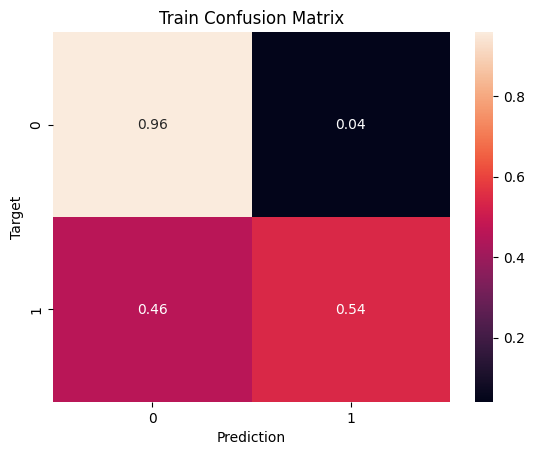

In [41]:
train_preds = predict_and_plot(X_train, train_targets, 'Train')

Accuracy: 87.09%


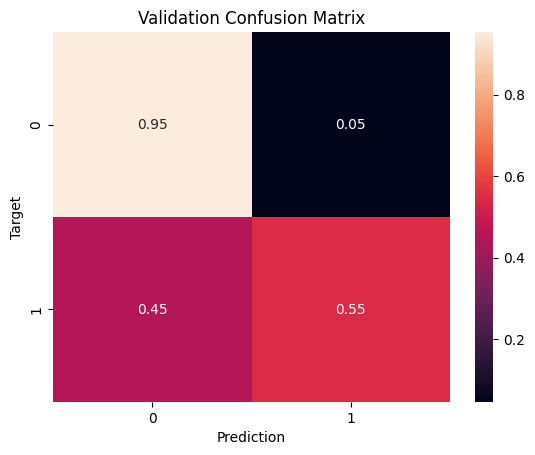

In [42]:
val_preds = predict_and_plot(X_val, val_targets, 'Validation')

In [43]:
def get_f1_score(inputs, targets, name=''):
  preds = model.predict(inputs)

  f1_score_ = f1_score(targets, preds)
  print(f"F1 score {name}: {f1_score_:.2f}%")

get_f1_score(X_train, train_targets, 'Training')
get_f1_score(X_val, val_targets, 'Validation')

F1 score Training: 0.64%
F1 score Validation: 0.63%


In [44]:
def compute_auroc_and_build_roc(inputs, targets, name=''):
  # Predict probabilities
  y_pred_proba = model.predict_proba(inputs)[:, 1]

  # Compute ROC curve
  fpr, tpr, thresholds = roc_curve(targets, y_pred_proba)

    # Compute AUROC
  roc_auc = auc(fpr, tpr)
  print(f'AUROC for {name}: {roc_auc:.2f}')

  # Plot the ROC curve
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
  plt.legend(loc="lower right")
  plt.show()

AUROC for Training: 0.88


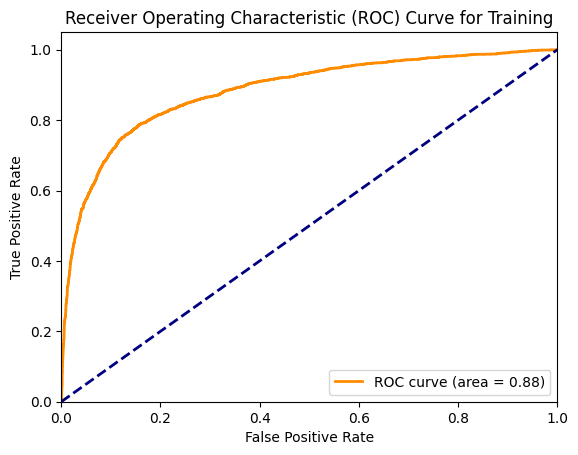

AUROC for Validation: 0.88


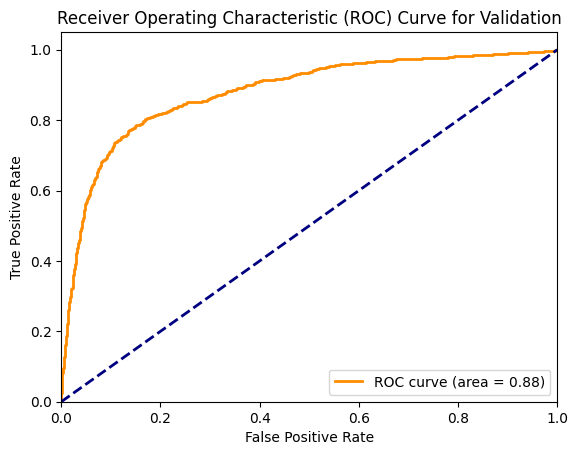

In [45]:
compute_auroc_and_build_roc(X_train, train_targets, 'Training')
compute_auroc_and_build_roc(X_val, val_targets, 'Validation')

**Спостереження**

у моделі дуже гарні показники: Accuracy 0,87, F1 score 0.64 та 0,63 на тренувальних та валідаційних даних відповідно, AUROC 0.88. Модель дуже добре передбачає цільову змінну.

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [46]:
def all_no(inputs):
    return np.full(len(inputs), 0)

In [47]:
accuracy_score(train_targets, all_no(X_train))

0.7965333333333333

In [48]:
accuracy_score(val_targets, all_no(X_val))

0.7965333333333333

**Спостреження**

Мажоритарний клас у нас негативиний, тож створювали передбачення якби модель казала завди НІ. ПРи такому підході, accuracy score 0,79, що є нижчим ніж accuracy score у натренированої моделі. Висновок: наша натренирована модель передбачає значно краще за вгадування методом казати завжди НІ.  

9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [49]:
log_reg = {
    'model': model,
    'scaler': scaler,
    'encoder': encoder,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

In [50]:
joblib.dump(log_reg, 'drive/MyDrive/ML Course/Data/bank-customer-churn-prediction_data/log_reg.joblib')

['drive/MyDrive/ML Course/Data/bank-customer-churn-prediction_data/log_reg.joblib']

In [51]:
model_2 = joblib.load('drive/MyDrive/ML Course/Data/bank-customer-churn-prediction_data/log_reg.joblib')

10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [52]:
import warnings
warnings.filterwarnings("ignore")

def predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, input_df: pd.DataFrame):
    input_df.drop(columns=['CustomerId', 'Surname'], inplace=True)
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[numeric_cols + encoded_cols]
    prob = model.predict_proba(X_input)[:,1]
    return prob

In [53]:
predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, train_raw_df[:5].copy())

array([0.00642569, 0.03706968, 0.36971138, 0.37670638, 0.97583457])

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [54]:
test_raw_df = pd.read_csv(data_dir + '/test.csv')

In [55]:
test_raw_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,15000,15594796.0,Chu,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86
1,15001,15642821.0,Mazzi,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28
2,15002,15716284.0,Onyekachi,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45
3,15003,15785078.0,Martin,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87
4,15004,15662955.0,Kenechukwu,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97


In [56]:
test_raw_df['Exited'] = predict_raw_df(
    scaler,
    encoder,
    numeric_cols,
    categorical_cols,
    test_raw_df
)

In [57]:
test_raw_df.head()

,id,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_Female,Gender_Male,Geography_France,Geography_Germany,Geography_Spain,Exited
0,15000,0.365155,Germany,Male,0.222222,0.2,0.696265,0.000000,1.0,1.0,0.789477,0.0,1.0,0.0,1.0,0.0,0.074950
1,15001,0.286396,France,Male,0.388889,0.5,0.000000,0.333333,1.0,1.0,0.337131,0.0,1.0,1.0,0.0,0.0,0.034767
2,15002,0.656325,France,Male,0.462963,0.8,0.000000,0.333333,1.0,0.0,0.783859,0.0,1.0,1.0,0.0,0.0,0.150961
3,15003,0.682578,Spain,Male,0.500000,0.3,0.000000,0.000000,1.0,1.0,0.834571,0.0,1.0,0.0,0.0,1.0,0.196458
4,15004,0.384248,Spain,Male,0.462963,0.8,0.000000,0.333333,1.0,1.0,0.718421,0.0,1.0,0.0,0.0,1.0,0.055247


12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [58]:
sample_submission_df = pd.read_csv(data_dir + '/sample_submission.csv')

In [59]:
sample_submission_df.head()

,id,Exited
0,15000,0.5
1,15001,0.5
2,15002,0.5
3,15003,0.5
4,15004,0.5


In [60]:
sample_submission_df['Exited'] = test_raw_df['Exited']

In [61]:
sample_submission_df.head()

,id,Exited
0,15000,0.074950
1,15001,0.034767
2,15002,0.150961
3,15003,0.196458
4,15004,0.055247


In [63]:
sample_submission_df.to_csv('drive/MyDrive/ML Course/Data/bank-customer-churn-prediction_data/submission_log_reg.csv', index=False)